In [137]:
using Plots, DifferentialEquations, LaTeXStrings, Printf, QuadGK, Statistics, Roots

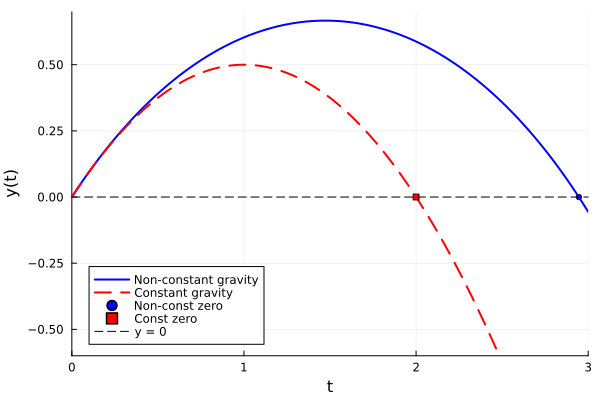


SUMMARY COMPARISON

Difference between cases:           Δt = 0.945615455343


In [138]:
function nonconstant_grav!(du, u, p, t)
    epsilon = p
    y, dy = u
    
    du[1] = dy  # y' = dy/dt
    du[2] = -1.0 / (epsilon * y + 1.0)^2  # y'' = -1/(ε*y + 1)^2
end

# Define the ODE system for constant gravity
# y''(t) = -1 (constant acceleration)
function constant_grav!(du, u, p, t)
    epsilon = p  # Not used, but keeping parameter structure consistent
    y, dy = u
    
    du[1] = dy  # y' = dy/dt
    du[2] = -1.0 # y'' = -1 (constant gravity)
end

ϵ = 0.5
t_end = 3.0

# Initial conditions: y(0) = 0, y'(0) = 1
u0 = [0.0, 1.0]
tspan = (0.0, t_end)
    
# Define the problems
prob_nonconst = ODEProblem(nonconstant_grav!, u0, tspan, ϵ)
prob_const = ODEProblem(constant_grav!, u0, tspan, ϵ)

# Solve both with high accuracy
sol_nonconst = solve(prob_nonconst, Tsit5() )
sol_const = solve(prob_const, Tsit5() )
    
# Create time points for comparison
t_vals = range(0, t_end, length=1000)
    
# Compute numerical solutions
y_nonconst = [sol_nonconst(t)[1] for t in t_vals]
y_const = [sol_const(t)[1] for t in t_vals]

# Plot both solutions for comparison
plot(t_vals, y_nonconst, label="Non-constant gravity", linewidth=2, color=:blue)
plot!(t_vals, y_const, label="Constant gravity", linewidth=2, color=:red, linestyle=:dash)
hline!([0.0], color=:black, linestyle=:dot, alpha=0.5, label="y = 0")
xlabel!("t")
ylabel!("y(t)")
title!("Toy Rocket Launch")

# Define functions that return y(t) for root finding
function y_nonconst_function(t)
    if t < 0 || t > t_end
        return NaN
    end
    return sol_nonconst(t)[1]
end

function y_const_function(t)
    if t < 0 || t > t_end
        return NaN
    end
    return sol_const(t)[1]
end

# Function to find root with bracketing
function find_root_with_bracketing(func, initial_guess, case_name)
    
    # Check the sign at the initial guess
    y_guess = func(initial_guess)
    
    # Search for a bracket around the initial guess
    bracket_found = false
    a, b = initial_guess - 1.0, initial_guess + 1.0
    
    # Expand search if needed
    for width in [0.5, 1.0, 1.5, 2.0]
        a = max(0.0, initial_guess - width)
        b = min(t_end, initial_guess + width)
        
        ya, yb = func(a), func(b)
        
        if ya * yb < 0  # Different signs, root exists in interval
            bracket_found = true
            break
        end
    end
    
    if bracket_found
        # Use Brent's method to find the root with high precision
        root_t = find_zero(func, (a, b), Roots.Brent())
        root_y = func(root_t)
        
        return root_t, root_y, true
    else
        println("Could not bracket the root near t = $initial_guess")
        
        # Examine function values more carefully
        test_points = range(0.0, t_end, length=21)
        println("\nFunction values across the domain:")
        for t_test in test_points
            y_test = func(t_test)
            @printf("t = %.3f, y(t) = %.6f\n", t_test, y_test)
        end
        
        return NaN, NaN, false
    end
end

# Find roots for both cases
# initial guess for nonconstant gravity case
initial_guess = 2.94

# Non-constant gravity case
root_nonconst, root_y_nonconst, found_nonconst = find_root_with_bracketing(
    y_nonconst_function, initial_guess, "Non-constant gravity"
)

# Constant gravity case
root_const, root_y_const, found_const = find_root_with_bracketing(
    y_const_function, 2.0, "Constant gravity"
)

# Create comprehensive comparison plot
comparison_plot = plot(t_vals, y_nonconst, label="Non-constant gravity", 
                      linewidth=2, color=:blue)
plot!(t_vals, y_const, label="Constant gravity", 
      linewidth=2, color=:red, linestyle=:dash)

# Add zero crossings if found
if found_nonconst
    scatter!([root_nonconst], [0.0], color=:blue, markersize=3, 
            label="Non-const zero", markershape=:circle)
end

if found_const
    scatter!([root_const], [0.0], color=:red, markersize=3, 
            label="Const zero", markershape=:square)
end

hline!([0.0], color=:black, linestyle=:dash, label="y = 0")
xlabel!("t")
ylabel!("y(t)")
xlims!(0, t_end)
ylims!(-0.6, 0.7)

display(comparison_plot)

# Summary comparison
println("\n" * "="^60)
println("SUMMARY COMPARISON")
println("="^60)

if found_nonconst && found_const
    difference = abs(root_nonconst - root_const)
    analytical_diff = abs(root_const - 2.0)
    @printf("\nDifference between cases:           Δt = %.12f\n", difference)
end

In [139]:
# Function to compute coefficient c_n
function c(n::Int)
    return 2^(n+1) * (n+1) / ((2n+1) * binomial(2n, n))
end

# Function to evaluate truncated series
function t_hit_series(eps::Float64, N::Int)
    s = 0.0
    for n in 0:(N-1)
        s += c(n) * eps^n
    end
    return s
end


t_hit_series (generic function with 1 method)

In [140]:
# Example: 25 terms
eps = 0.5
N = 30
println("analytic: ", t_hit_series(eps, N))
println("numeric:  ", root_nonconst)

analytic: 2.9455994348748593
numeric:  2.9456154553428595
